In [1]:
import pandas as pd
import numpy as np

# Read in Files

In [2]:
sessions = pd.read_csv("sessions.csv")
events = pd.read_csv("events.csv")
attr = pd.read_csv("small_attributes.csv")

In [3]:
sessions = sessions.drop(columns="Unnamed: 0")
events = events.drop(columns=["Unnamed: 0", "app_id", "event"])
attr = attr.drop(columns="Unnamed: 0")

# Feature Engineer

### Make column for top two countries

In [6]:
purchasers = events.groupby("user_id_hash")["purchases"].max()

In [7]:
sessions = sessions.join(purchasers, on="user_id_hash", how="left")

In [8]:
pop_country = sessions.groupby("country")["purchases"].sum().sort_values(ascending=False)

In [9]:
top_country = list(pop_country.iloc[:2].keys())

In [10]:
top_country

['US', 'GB']

In [11]:
sessions[top_country[0]] = np.zeros((len(sessions),))
sessions[top_country[1]] = np.zeros((len(sessions),))

In [23]:
sessions.US = sessions[sessions.country=="US"]["US"].replace({0.0:1.0})
sessions.GB = sessions[sessions.country=="GB"]["GB"].replace({0.0:1.0})
sessions.US = sessions.US.fillna(value=0.0)
sessions.GB = sessions.GB.fillna(value=0.0)

In [29]:
unique_users = pd.DataFrame(events["user_id_hash"].unique(), columns=["user_id_hash"])

In [31]:
user_to_top_country = sessions.groupby("user_id_hash")[["US", "GB"]].max()

In [36]:
unique_users = unique_users.join(user_to_top_country, on="user_id_hash", how="left")

### Session Counts

In [38]:
session_counts = sessions[["user_id_hash", "session_index"]].groupby("user_id_hash").max()

In [39]:
unique_users = unique_users.join(session_counts, on="user_id_hash", how="left")

### Session Count / Duration Ratio

In [57]:
duration_sum = sessions[["user_id_hash", "previous_sessions_duration"]].groupby("user_id_hash").sum()
# session_max = sessions[["user_id_hash", "session_index"]].groupby("user_id_hash").max()
# dur_ses = duration_sum.join(session_max, how="outer")
# dur_ses["duration_session_ratio"] = dur_ses.previous_sessions_duration / dur_ses.session_index
# dur_ses = dur_ses.drop(columns=["session_index"])

In [58]:
duration_sum = duration_sum / 60 / 60

In [60]:
unique_users = unique_users.join(duration_sum, on="user_id_hash", how="left")

In [61]:
unique_users.previous_sessions_duration = unique_users.previous_sessions_duration.fillna(value=0.0)

### Join Attribute Columns

In [63]:
attr.index = attr.user_id_hash

In [64]:
attr = attr.drop(columns="user_id_hash")

In [65]:
unique_users = unique_users.join(attr, on="user_id_hash", how="left")

# Create Target

In [68]:
dec_events = events[events.event_timestamp >= "2018-12-01 00:00:00.000"].sort_values(by="event_timestamp")

In [69]:
week1 = dec_events[dec_events.event_timestamp < "2018-12-08 00:00:00.000"]
week2 = dec_events[dec_events.event_timestamp < "2018-12-15 00:00:00.000"]

In [70]:
week1_buyers = week1[["user_id_hash", "purchases"]].groupby("user_id_hash", as_index=False).sum()
week1_buyers["week1_purchaser"] = [1 if x > 0 else 0 for x in week1_buyers.purchases]
week1_buyers = week1_buyers.drop(columns=["purchases"])
week2_buyers = week2[["user_id_hash", "purchases"]].groupby("user_id_hash").sum()
week2_buyers["week2_purchaser"] = [1 if x > 0 else 0 for x in week2_buyers.purchases]
week2_buyers = week2_buyers.drop(columns=["purchases"])

In [71]:
dec_df = week1_buyers.join(week2_buyers, on="user_id_hash", how="left")

In [72]:
dec_df.index = dec_df.user_id_hash
dec_df = dec_df.drop(columns="user_id_hash")

In [73]:
unique_users = unique_users.join(dec_df, on="user_id_hash", how="left").fillna(value=0)

In [215]:
unique_users.to_csv("/dev/shm/unique_users.csv")

# Create Model

In [76]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

In [55]:
# unique_users = pd.read_csv("unique_users.csv").drop(columns="Unnamed: 0")

In [77]:
len(unique_users) * 0.85

527850.85

In [78]:
train, test = unique_users.iloc[:527850], unique_users.iloc[527850:]

In [80]:
X_train = train.drop(columns=["user_id_hash", "week1_purchaser", "week2_purchaser"])
X_test = test.drop(columns=["user_id_hash", "week1_purchaser", "week2_purchaser"])
y1_train = train.week1_purchaser
y2_train = train.week2_purchaser
y1_test = test.week1_purchaser
y2_test = test.week2_purchaser

In [137]:
len(X.columns)

6

In [197]:
# xg_search_space = {"learning_rate":np.linspace(0.05, 0.2, 4), "subsample":np.linspace(0.8, 1.0, 4), 
#                "n_estimators":[50, 100, 150, 200], "max_depth":[1,2,3]}
rf_search_space = {"max_depth":[40,50,60]}

In [198]:
xg = XGBClassifier(njobs=-1, learning_rate=0.1, n_estimators=150, max_depth=3)
rf = RandomForestClassifier(n_jobs=-1, max_features=5, n_estimators=100, min_samples_leaf=40)
lr = LogisticRegression()

In [199]:
search = GridSearchCV(rf, rf_search_space, cv=10)

In [200]:
search.fit(X_train, y1_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [40, 50, 60]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [201]:
search.best_params_

{'max_depth': 40}

In [202]:
best_est = search.best_estimator_

In [203]:
week1 = best_est.fit(X_train, y1_train.values)
week2 = best_est.fit(X_train, y2_train.values)

In [204]:
week1_pred = week1.predict_proba(X_test)[:,1]
week1_pred2 = week1.predict_proba(X_train)[:,1]
week2_pred = week2.predict_proba(X_test)[:,1]
week2_pred2 = week2.predict_proba(X_train)[:,1]

In [205]:
roc_auc_score(y1_test, week1_pred)

0.9481132028566859

In [206]:
roc_auc_score(y2_test, week2_pred)

0.9492683428785006

In [207]:
roc_auc_score(y1_train, week1_pred2)

0.9773119289508729

In [208]:
roc_auc_score(y2_train, week2_pred2)

0.9779664513269934

# Predictions

In [209]:
X = unique_users.drop(columns=["user_id_hash", "week1_purchaser", "week2_purchaser"])
y1 = unique_users.week1_purchaser
y2 = unique_users.week2_purchaser

In [210]:
full_week1 = best_est.fit(X, y1)
full_week2 = best_est.fit(X, y2)

In [211]:
full_week1_pred = full_week1.predict_proba(X)[:,1]
full_week2_pred = full_week2.predict_proba(X)[:,1]

In [212]:
roc_auc_score(y1, full_week1_pred)

0.977333895217746

In [213]:
roc_auc_score(y2, full_week2_pred)

0.9779774906124299

In [107]:
full = np.vstack((unique_users.user_id_hash, full_week1_pred, full_week2_pred))

In [108]:
full_df = pd.DataFrame(full).T

In [109]:
full_df.index = full_df[0]
full_df = full_df.drop(columns=0)

In [110]:
full_df.columns = ["week1", "week2"]

In [111]:
submission = pd.read_csv("sample_submission_2.csv")

In [114]:
pred = submission.join(full_df, on="user_id_hash", how="left")

In [115]:
pred = pred.drop(columns=["user_purchase_binary_7_days", "user_purchase_binary_14_days"])

In [116]:
pred.columns = ["user_id_hash", "user_purchase_binary_7_days", "user_purchase_binary_14_days"]

In [122]:
len(pred[pred.user_purchase_binary_7_days.isna()])

252

In [123]:
pred.user_purchase_binary_7_days = pred.user_purchase_binary_7_days.fillna(value=np.mean(full_week1_pred))
pred.user_purchase_binary_14_days = pred.user_purchase_binary_14_days.fillna(value=np.mean(full_week2_pred))

In [124]:
pred.to_csv("/dev/shm/prediction.csv", index=False)

In [125]:
len(pred)

312568

In [134]:
full_week1.feature_importances_

array([0.08335115, 0.01751509, 0.24698984, 0.38490211, 0.11809385,
       0.14914797])

# NEW MODEL

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("../data/new_train.csv")

In [18]:
for col in df:
    if df[col].isna().any():
        print(col)

### Fill NaN

In [17]:
df.event_value = df.event_value.fillna(value=0)
df.event_value_per_session = df.event_value_per_session.fillna(value=0)

In [9]:
df.columns

Index(['user_id_hash', 'session_index', 'duration_session_ratio',
       'week1_purchaser', 'week2_purchaser', 'event_value',
       'event_value_per_session', 'US', 'GB', 'previous_sessions_duration',
       'avg_count_per_session', 'activity_variance', 'Week_1_Count',
       'Week_2_Count', 'Week_3_Count', 'Week_4_Count', 'Week_5_Count',
       'Week_6_Count', 'Week_7_Count', 'Week_8_Count', 'Week_9_Count',
       'Week_10_Count'],
      dtype='object')

In [375]:
# df.to_csv("../data/clean_train.csv")

In [364]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [201]:
X = df.drop(columns=["week1_purchaser", "week2_purchaser", "user_id_hash"])
y1 = df.week1_purchaser
y2 = df.week2_purchaser

In [202]:
split = int(len(df) * 0.5)

In [203]:
len(df) * 0.5

309434.0

Using 0.5 of the data to train since we are submitting predictions for about 312,000 users

In [204]:
X_train, X_test = X[:split], X[split:]
y1_train, y1_test = y1[:split], y2[split:]
y2_train, y2_test = y2[:split], y2[split:]

In [264]:
len(X_train.columns)*.85

16.15

In [276]:
# rf_1 = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_leaf=15, max_features=0.8)
rf_2 = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_leaf=13, max_features=0.8)
# xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, n_jobs=-1, subsample=0.8)
xgb = XGBClassifier(max_depth=3, learning_rate=0.25, n_estimators=200, n_jobs=-1, 
                    colsample_bytree=0.85)

### Random Forest / XGB

In [277]:
xgb_week1 = xgb.fit(X_train, y1_train)
xgb_week2 = xgb.fit(X_train, y2_train)
# rf2_week1 = rf_2.fit(X_train, y1_train)
# rf2_week2 = rf_2.fit(X_train, y2_train)

<Figure size 1080x720 with 0 Axes>

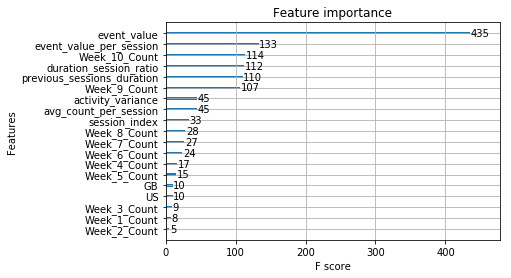

In [370]:
plt.figure(figsize=(15, 10))
plot_importance(xgb_week1)
plt.show()

In [359]:
sorted(list(zip(X_train.columns, rf2_week1.feature_importances_)), key=lambda x: x[1], reverse=True)

[('event_value', 0.3000057418527219),
 ('Week_9_Count', 0.18795672211747413),
 ('event_value_per_session', 0.17678129768033224),
 ('Week_10_Count', 0.13913719380217937),
 ('duration_session_ratio', 0.048000369191155634),
 ('previous_sessions_duration', 0.03271157199856122),
 ('session_index', 0.028618519936984454),
 ('avg_count_per_session', 0.01439157516097158),
 ('activity_variance', 0.011938313647886167),
 ('Week_5_Count', 0.010506893237733628),
 ('Week_4_Count', 0.009220091277942656),
 ('Week_7_Count', 0.009212592562425641),
 ('Week_6_Count', 0.008545231834580369),
 ('Week_8_Count', 0.00842010856054275),
 ('Week_3_Count', 0.006829372058571132),
 ('Week_2_Count', 0.003885176355839665),
 ('US', 0.0024559043342664622),
 ('Week_1_Count', 0.0011194682280625196),
 ('GB', 0.0002638561617686766)]

In [358]:
sorted(list(zip(X_train.columns, xgb_week1.feature_importances_)), key=lambda x: x[1], reverse=True)

[('event_value', 0.33799535),
 ('event_value_per_session', 0.1033411),
 ('Week_10_Count', 0.08857809),
 ('duration_session_ratio', 0.087024085),
 ('previous_sessions_duration', 0.08547009),
 ('Week_9_Count', 0.083139084),
 ('avg_count_per_session', 0.034965035),
 ('activity_variance', 0.034965035),
 ('session_index', 0.025641026),
 ('Week_8_Count', 0.021756021),
 ('Week_7_Count', 0.02097902),
 ('Week_6_Count', 0.018648019),
 ('Week_4_Count', 0.013209013),
 ('Week_5_Count', 0.011655011),
 ('US', 0.007770008),
 ('GB', 0.007770008),
 ('Week_3_Count', 0.006993007),
 ('Week_1_Count', 0.0062160064),
 ('Week_2_Count', 0.003885004)]

In [278]:
xgb_pred1 = xgb_week1.predict_proba(X_test)[:,1]
xgb_pred2 = xgb_week2.predict_proba(X_test)[:,1]
xgb_pred1_train = xgb_week1.predict_proba(X_train)[:,1]
xgb_pred2_train = xgb_week2.predict_proba(X_train)[:,1]
# rf2_pred1 = rf2_week1.predict_proba(X_test)[:,1]
# rf2_pred2 = rf2_week2.predict_proba(X_test)[:,1]
# rf2_pred1_train = rf2_week1.predict_proba(X_train)[:,1]
# rf2_pred2_train = rf2_week2.predict_proba(X_train)[:,1]

In [279]:
print(f"XGB Week1 Train: {roc_auc_score(y1_train, xgb_pred1_train)}")
print(f"XGB Week1 Val: {roc_auc_score(y1_test, xgb_pred1)}")
print(f"XGB Week2 Train: {roc_auc_score(y2_train, xgb_pred2_train)}")
print(f"XGB Week2 Val: {roc_auc_score(y2_test, xgb_pred2)}")

XGB Week1 Train: 0.9986922185292719
XGB Week1 Val: 0.9950401347808341
XGB Week2 Train: 0.9991247812436075
XGB Week2 Val: 0.9950401347808341


In [275]:
print(f"XGB Week1 Train: {roc_auc_score(y1_train, xgb_pred1_train)}")
print(f"XGB Week1 Val: {roc_auc_score(y1_test, xgb_pred1)}")
print(f"XGB Week2 Train: {roc_auc_score(y2_train, xgb_pred2_train)}")
print(f"XGB Week2 Val: {roc_auc_score(y2_test, xgb_pred2)}")

XGB Week1 Train: 0.9981355879523023
XGB Week1 Val: 0.9953257632651523
XGB Week2 Train: 0.998473245380111
XGB Week2 Val: 0.9953257632651523


In [216]:
print(f"RF2 Week1 Train: {roc_auc_score(y1_train, rf2_pred1_train)}")
print(f"RF2 Week1 Val: {roc_auc_score(y1_test, rf2_pred1)}")
print(f"RF2 Week2 Train: {roc_auc_score(y2_train, rf2_pred2_train)}")
print(f"RF2 Week2 Val: {roc_auc_score(y2_test, rf2_pred2)}")

RF2 Week1 Train: 0.9986829646101931
RF2 Week1 Val: 0.9950142117410427
RF2 Week2 Train: 0.9991089747389384
RF2 Week2 Val: 0.9950142117410427


### Train full RF / XGB

In [43]:
unique_users = pd.DataFrame(df.user_id_hash.unique(), columns=["user_id_hash"])

In [330]:
submission = pd.read_csv("../data/sample_submission_2.csv")

In [340]:
submission.user_id_hash[1000]

'b7b3a2242f219edf2b9cef57aa586e7e0c80f4519e8f3f96709211c212c73996'

In [418]:
new_week1 = rf_2.fit(X, y1)
new_week2 = rf_2.fit(X, y2)
new_week1_pred = new_week1.predict_proba(X)[:,1]
new_week2_pred = new_week2.predict_proba(X)[:,1]
print(f"Week1 Train: {roc_auc_score(y1, new_week1_pred)}")
print(f"Week2 Train: {roc_auc_score(y2, new_week2_pred)}")

Week1 Train: 0.9983562006020161
Week2 Train: 0.9989285533910622


In [280]:
new_xgb_week1 = xgb.fit(X, y1)
new_xgb_week2 = xgb.fit(X, y2)
xgb_week1_pred = new_xgb_week1.predict_proba(X)[:,1]
xgb_week2_pred = new_xgb_week2.predict_proba(X)[:,1]
print(f"Week1 Train: {roc_auc_score(y1, xgb_week1_pred)}")
print(f"Week2 Train: {roc_auc_score(y2, xgb_week2_pred)}")

Week1 Train: 0.9973394186601433
Week2 Train: 0.9978126463948638


In [419]:
week1_pred = new_week1_pred
week2_pred = new_week2_pred

In [420]:
predictions = pd.DataFrame(np.vstack((unique_users.user_id_hash, week1_pred, week2_pred))).T

In [421]:
predictions.columns = ["user_id_hash", "week1", "week2"]

In [422]:
predictions.index = predictions["user_id_hash"]
predictions = predictions.drop(columns="user_id_hash")

In [423]:
submission = submission.join(predictions, on="user_id_hash", how="left")

In [424]:
submission = submission.drop(columns=["user_purchase_binary_7_days", "user_purchase_binary_14_days"])
submission.columns = ["user_id_hash", "user_purchase_binary_7_days", "user_purchase_binary_14_days"]

In [425]:
submission.user_purchase_binary_7_days.isna().astype(int).sum()

1354

In [426]:
np.mean(week1_pred)

0.009895202327160433

In [427]:
submission.user_purchase_binary_7_days = submission.user_purchase_binary_7_days.fillna(value=np.mean(week1_pred))
submission.user_purchase_binary_14_days = submission.user_purchase_binary_14_days.fillna(value=np.mean(week2_pred))

In [428]:
submission.to_csv("../data/rf_prediction.csv", index=False)